# Imports and Setup.

In [ ]:
%%capture
!pip -q install rasterio
!pip -q install torch
!pip -q install torchvision
!pip -q install albumentations
!pip -q install segmentation-models-pytorch
!pip -q install tqdm

In [ ]:
import os
import torch
import rasterio
import albumentations as A
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from torchvision import transforms as T
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.nn.functional as F
#import torchsummary
from tqdm import tqdm

# Data manipulation and visualization
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import numpy as np
from sklearn.metrics import f1_score

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Download training data to local compute node

## Mount your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Compress training files, copy over and uncompress

In [ ]:
# # Navigate to the shared directory
# %cd /content/drive/MyDrive
# # Zip the data
# !zip -r /content/Sentinel_training.zip Sentinel_training
# #!zip -r /content/masks.zip masks
# #!zip -r /content/masks_10m.zip masks_10m
# !zip -r /content/training_masks.zip training_masks
# #!zip -r /content/masks_100m.zip masks_100m
# #!zip -r /content/masks_200m.zip masks_200m
# # Unzip the files
# !unzip /content/Sentinel_training.zip -d /content
# #!unzip /content/masks.zip -d /content
# #!unzip /content/masks_10m.zip -d /content
# !unzip /content/training_masks.zip -d /content
# #!unzip /content/masks_100m.zip -d /content
# #!unzip /content/masks_200m.zip -d /content

# Custom classes and functions to handle Sentinel 1/2 data and corresponding masks

In [ ]:
# Custom Dataset class for Sentinel 1/2 bands and mask
class Sentinel2Dataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, additional_bands=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.additional_bands = additional_bands if additional_bands else []

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask using rasterio
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        with rasterio.open(image_path) as src:
            # Initialize dictionary for all required bands
            bands = {desc: src.read(i + 1) for i, desc in enumerate(src.descriptions) if desc in ['B4', 'B3', 'B2'] + self.additional_bands}

            # Ensure all specified bands are present
            required_bands = ['B4', 'B3', 'B2'] + self.additional_bands
            for band in required_bands:
                if band not in bands:
                    raise ValueError(f"Missing band {band} in image: {image_path}")

            # Rescale RGB bands (B4, B3, B2) only
            rgb_image = np.stack([bands['B4'], bands['B3'], bands['B2']], axis=-1)
            rgb_image = np.clip(rgb_image, 0, 2000) / 2000  # Scaling between 0 and 1

            # Stack additional bands without normalization
            other_band_images = [bands[band] for band in self.additional_bands]
            if other_band_images:
                full_image = np.concatenate([rgb_image] + [np.expand_dims(b, axis=-1) for b in other_band_images], axis=-1)
            else:
                full_image = rgb_image


        with rasterio.open(mask_path) as mask_src:
            mask = mask_src.read(1)

        # Ensure both image and mask are numpy arrays before applying transforms
        image = np.array(full_image)
        mask = np.array(mask)

        if check_for_nan_inf(image) or check_for_nan_inf(mask):
            raise ValueError(f"NaN or Inf values found in data: {image_path}, {mask_path}")

        # Apply any transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Only convert to PyTorch tensors if not already tensors (skip if the transform does it)
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image).permute(2, 0, 1).float()  # Channels first
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).long()

        return image, mask

    # def __getitem__(self, idx):
    #     image_path = self.image_paths[idx]
    #     mask_path = self.mask_paths[idx]

    #     try:
    #         with rasterio.open(image_path) as src:
    #             bands = {desc: src.read(i + 1) for i, desc in enumerate(src.descriptions) if desc in ['B4', 'B3', 'B2'] + self.additional_bands}

    #             required_bands = ['B4', 'B3', 'B2'] + self.additional_bands
    #             for band in required_bands:
    #                 if band not in bands:
    #                     raise ValueError(f"Missing band {band} in image: {image_path}")

    #             rgb_image = np.stack([bands['B4'], bands['B3'], bands['B2']], axis=-1)
    #             rgb_image = np.clip(rgb_image, 0, 2000) / 2000

    #             other_band_images = [bands[band] for band in self.additional_bands]
    #             if other_band_images:
    #                 full_image = np.concatenate([rgb_image] + [np.expand_dims(b, axis=-1) for b in other_band_images], axis=-1)
    #             else:
    #                 full_image = rgb_image

    #         with rasterio.open(mask_path) as mask_src:
    #             mask = mask_src.read(1)

    #         image = np.array(full_image)
    #         mask = np.array(mask)

    #         if check_for_nan_inf(image) or check_for_nan_inf(mask):
    #             raise ValueError(f"NaN or Inf values found in data: {image_path}, {mask_path}")

    #     except (rasterio.errors.RasterioIOError, ValueError) as e:
    #         print(f"⚠️ Skipping corrupt or invalid file: {image_path} / {mask_path}\nError: {e}")
    #         # Skip this sample cleanly by raising IndexError
    #         raise IndexError(f"Invalid sample at index {idx}")

    #     if self.transform:
    #         augmented = self.transform(image=image, mask=mask)
    #         image = augmented['image']
    #         mask = augmented['mask']

    #     if not isinstance(image, torch.Tensor):
    #         image = torch.from_numpy(image).permute(2, 0, 1).float()
    #     if not isinstance(mask, torch.Tensor):
    #         mask = torch.from_numpy(mask).long()

    #     return image, mask


NEW DATATSET CLASS

In [ ]:
# import glob
# import random

# def get_all_tif_files(folder):
#     return sorted(glob.glob(os.path.join(folder, "*.tif"))) + \
#            sorted(glob.glob(os.path.join(folder, "*.TIF")))

# mask_dir = "/content/drive/MyDrive/Khushi_drive/All_Masks_TIF"
# image_dir = "/content/drive/MyDrive/Khushi_drive/GEE_Exports_all"

# mask_paths = get_all_tif_files(mask_dir)
# image_paths = get_all_tif_files(image_dir)

# print(f"✅ Found {len(mask_paths)} masks and {len(image_paths)} images.")

# image_mask_pairs = []

# for mask_path in mask_paths:
#     mask_filename = os.path.basename(mask_path)  # e.g., "1_id_200.tif"
#     core_id = "_".join(mask_filename.split("_")[1:])  # id_200.tif
#     image_path = os.path.join(image_dir, core_id)
#     if os.path.exists(image_path):
#         image_mask_pairs.append((image_path, mask_path))

# # Shuffle and select random 400
# random.shuffle(image_mask_pairs)
# image_mask_pairs = image_mask_pairs[:400]

# # Split into separate lists
# image_paths = [pair[0] for pair in image_mask_pairs]
# mask_paths = [pair[1] for pair in image_mask_pairs]

# print(f"Image directory: {image_dir}")
# print(f"Mask directory: {mask_dir}")
# print(f"Found {len(image_mask_pairs)} image-mask pairs (random 400)")


✅ Found 0 masks and 0 images.
Image directory: /content/drive/MyDrive/Khushi_drive/GEE_Exports_all
Mask directory: /content/drive/MyDrive/Khushi_drive/All_Masks_TIF
Found 0 image-mask pairs (random 400)


In [ ]:
# zero_masks = [p for p in mask_paths if os.path.basename(p).startswith("0_")]
# one_masks = [p for p in mask_paths if os.path.basename(p).startswith("1_")]

# print(f"🛩️ Airstrip present (1_): {len(one_masks)}")
# print(f"🚫 No airstrip (0_): {len(zero_masks)}")

🛩️ Airstrip present (1_): 0
🚫 No airstrip (0_): 0


In [ ]:
# import warnings
# warnings.filterwarnings('ignore', category=UserWarning, module='rasterio')

# class AirstripSentinelDataset(Dataset):
#     def __init__(self, image_paths, mask_paths, transform=None):
#         self.image_paths = image_paths
#         self.mask_paths = mask_paths
#         self.transform = transform

#         # Validate that we have actual positive samples
#         self._check_masks()

#     def _check_masks(self):
#         """Check if masks contain positive samples"""
#         positive_count = 0
#         for mask_path in self.mask_paths[:10]:  # Check first 10
#             try:
#                 with rasterio.open(mask_path) as msk:
#                     mask = msk.read(1)
#                     if mask.max() > 0:
#                         positive_count += 1
#                         print(f"✅ Found positive mask: {os.path.basename(mask_path)} - {mask.sum()} positive pixels")
#                     else:
#                         print(f"❌ Empty mask: {os.path.basename(mask_path)}")
#             except Exception as e:
#                 print(f"Error reading {mask_path}: {e}")

#         print(f"Positive masks found: {positive_count}/10")
#         if positive_count == 0:
#             print("⚠️  WARNING: No positive samples found! Check your mask files.")

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         img_path = self.image_paths[idx]
#         mask_path = self.mask_paths[idx]

#         try:
#             # Load image
#             with rasterio.open(img_path) as src:
#                 img = src.read([3, 4, 8])  # RGB-like Sentinel bands
#                 img = np.transpose(img, (1, 2, 0)).astype(np.float32)

#                 # Handle different possible value ranges
#                 if img.max() > 100:  # Likely 0-10000 range
#                     img = np.clip(img / 10000.0, 0, 1)
#                 elif img.max() > 10:  # Likely 0-255 range
#                     img = np.clip(img / 255.0, 0, 1)
#                 # else: already 0-1 range

#                 # Replace any NaN/inf values
#                 img = np.nan_to_num(img, nan=0.0, posinf=1.0, neginf=0.0)

#             # Load mask
#             with rasterio.open(mask_path) as msk:
#                 mask = msk.read(1).astype(np.float32)

#                 # Ensure binary mask
#                 mask = (mask > 0).astype(np.float32)

#                 # Replace any NaN/inf values
#                 mask = np.nan_to_num(mask, nan=0.0, posinf=1.0, neginf=0.0)

#             # Apply transforms
#             if self.transform:
#                 augmented = self.transform(image=img, mask=mask)
#                 img = augmented["image"]
#                 mask = augmented["mask"]

#             return img, mask.unsqueeze(0)

#         except Exception as e:
#             print(f"Error loading sample {idx}: {e}")
#             # Return a dummy sample to avoid breaking training
#             dummy_img = torch.zeros(3, 512, 512)
#             dummy_mask = torch.zeros(1, 512, 512)
#             return dummy_img, dummy_mask

In [ ]:
def check_for_nan_inf(data):
    """Checks for NaN or Inf values in NumPy data."""
    if np.isnan(data).any() or np.isinf(data).any():
        return True  # Found NaN or Inf
    else:
        return False  # No NaN or Inf


In [ ]:
# Augmentations using albumentations and PyTorch's ToTensor
def get_augmentations(option='train', optional_bands=None):
    # Define mean and std for RGB (B4, B3, B2)
    base_band_means = {'B4': 0.485, 'B3': 0.456, 'B2': 0.406}
    base_band_stds = {'B4': 0.229, 'B3': 0.224, 'B2': 0.225}

    # Define mean and std for additional optional bands
    optional_band_means = {'B8': 2987.760, 'B11': 1656.303, 'B12': 729.068, 'VV': -8.048, 'VH': -14.456, 'VV_VH_Ratio': 0.547}
    optional_band_stds = {'B8': 504.165, 'B11': 314.123, 'B12': 203.183, 'VV': 1.911, 'VH': 1.825, 'VV_VH_Ratio': 0.064}

    # Combine base bands and optional bands
    all_band_means = {**base_band_means, **optional_band_means}
    all_band_stds = {**base_band_stds, **optional_band_stds}

    # If optional_bands is specified, get only those; otherwise, default to RGB
    selected_bands = ['B4', 'B3', 'B2'] + (optional_bands if optional_bands else [])
    mean = tuple(all_band_means[band] for band in selected_bands)
    std = tuple(all_band_stds[band] for band in selected_bands)

    # Define augmentation pipeline based on phase
    augmentations = {
        'train': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
        ],
        'val': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
        ],
        'test': [
            A.CropNonEmptyMaskIfExists(width=224, height=224),
        ],
        'inference': [
            A.CenterCrop(width=224, height=224),
        ]
    }

    if option not in augmentations:
        raise ValueError("Invalid option. Choose from 'train', 'val', 'test', or 'inference'.")

    # Add normalization and tensor transformation
    augmentations[option].extend([
        A.Normalize(mean=mean, std=std, max_pixel_value=1.0),
        ToTensorV2(),
    ])

    # Return the Compose pipeline with additional mask target
    return A.Compose(augmentations[option], additional_targets={'mask': 'mask'})


In [ ]:
# # Augmentations using albumentations and PyTorch's ToTensor
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# def get_augmentations(option='train'):
#     # Mean and std for RGB bands (B4, B3, B2)
#     mean = (0.485, 0.456, 0.406)  # B4, B3, B2
#     std = (0.229, 0.224, 0.225)

#     # Define augmentation pipeline based on phase
#     augmentations = {
#         'train': [
#             A.CropNonEmptyMaskIfExists(width=224, height=224),
#             A.HorizontalFlip(p=0.5),
#             A.VerticalFlip(p=0.5),
#             A.RandomRotate90(p=0.5),
#         ],
#         'val': [
#             A.CropNonEmptyMaskIfExists(width=224, height=224),
#         ],
#         'test': [
#             A.CropNonEmptyMaskIfExists(width=224, height=224),
#         ],
#         'inference': [
#             A.CenterCrop(width=224, height=224),
#         ]
#     }

#     if option not in augmentations:
#         raise ValueError("Invalid option. Choose from 'train', 'val', 'test', or 'inference'.")

#     # Add normalization and tensor transformation
#     augmentations[option].extend([
#         A.Normalize(mean=mean, std=std, max_pixel_value=1.0),
#         ToTensorV2(),
#     ])

#     return A.Compose(augmentations[option], additional_targets={'mask': 'mask'})


In [ ]:
# def get_augmentations(train=True):
#     if train:
#         return A.Compose([
#             A.Resize(512, 512),
#             A.HorizontalFlip(p=0.5),
#             A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
#             # Remove A.Normalize() since we handle it in dataset
#             ToTensorV2()
#         ])
#     else:
#         return A.Compose([
#             A.Resize(512, 512),
#             ToTensorV2()
#         ])

In [ ]:
# UNet model with ResNet50 encoder
def get_model(in_channels=3):
    model = smp.Unet(
        encoder_name='resnet50',        # Choose encoder, ResNet50 in this case
        encoder_weights='imagenet',     # Use pre-trained weights
        in_channels=in_channels,                  # RGB, modify later for more channels
        classes=1,                      # Binary segmentation
    )
    return model

In [ ]:
# Training loop
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()

    total_loss = 0.0
    running_loss = 0.0
    running_total_pixels = 0.0
    running_correct_pixels = 0.0

    for batch_idx, (images, masks) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        # Change data type of masks to float32 before moving to device
        masks = masks.type(torch.float32).to(device).unsqueeze(1)  # Add channel dimension to masks
        images = images.float()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        ## Next line is an attempt at limiting loss from exploding.
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients to a maximum norm of 1
        optimizer.step()

        # Calculate per-pixel accuracy
        preds = torch.sigmoid(outputs) > 0.5  # Threshold to convert logits to binary predictions (for binary segmentation)
        correct_pixels = torch.sum(preds == masks).item()
        total_pixels = masks.numel()  # Total number of pixels in the batch

        # Calculate running loss and accuracy
        running_loss += loss.item() * images.size(0)
        running_correct_pixels += correct_pixels
        running_total_pixels += total_pixels

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_correct_pixels / running_total_pixels) * 100  # Pixel-wise accuracy
    print(f"Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

    return epoch_loss, epoch_accuracy

In [ ]:
def evaluate(model, dataloader, criterion, device, phase="val", plot=False):
    model.eval()

    running_loss = 0
    running_correct_pixels = 0
    total_iou = 0
    num_samples = 0
    running_total_pixels = 0
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0

    imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


    for i, (images, masks) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        masks = masks.to(device)

        # Add channel dimension to the target masks
        masks = masks.type(torch.float32)
        masks = masks.unsqueeze(1)


        with torch.set_grad_enabled(False):
            outputs = model(images)
            loss = criterion(outputs, masks)
            # Apply sigmoid to the outputs (for binary segmentation) and threshold
            preds = torch.sigmoid(outputs) > 0.5

        # Calculate per-pixel accuracy
        correct_pixels = torch.sum(preds == masks).item()
        total_pixels = masks.numel()
        running_correct_pixels += correct_pixels
        running_total_pixels += total_pixels

         # Calculate IoU and F1 score metrics
        for j in range(images.shape[0]):
            prediction = preds[j].squeeze(0)  # Remove channel dimension
            #prediction = (prediction > 0.5).float()  # Example threshold of 0.5
            iou = calculate_jaccard_index(prediction, masks[j])
            total_iou += iou

            # Calculate TP, FP, FN for F1 score
            true_positive = torch.sum((prediction == 1) & (masks[j] == 1)).item()
            false_positive = torch.sum((prediction == 1) & (masks[j] == 0)).item()
            false_negative = torch.sum((prediction == 0) & (masks[j] == 1)).item()

            total_true_positives += true_positive
            total_false_positives += false_positive
            total_false_negatives += false_negative
            num_samples += 1


        if plot:
            # Plot image, mask, and prediction for a sample in the batch
            for i in range(images.shape[0]):  # Loop through batch
                image = images[i, :3, :, :].cpu().permute(1, 2, 0).numpy()  # Move to CPU, permute for plotting
                image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)
                mask = masks[i].cpu().squeeze().numpy()
                prediction = outputs[i].cpu().squeeze()

                # Apply sigmoid for binary segmentation if your model output is logits.
                prediction = torch.sigmoid(prediction)

                # Threshold predictions (adjust threshold as needed)
                prediction = (prediction > 0.5).float().numpy()  # Example threshold of 0.5

                plot_predictions(image, mask, prediction) # Call plot function

        running_loss += loss.item() * images.size(0)

    # Calculate metrics
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_correct_pixels / running_total_pixels) * 100  # Pixel-wise accuracy
    average_iou = total_iou / num_samples

    # Calculate Precision, Recall, and F1 score
    precision = total_true_positives / (total_true_positives + total_false_positives + 1e-8)
    recall = total_true_positives / (total_true_positives + total_false_negatives + 1e-8)
    f1_score_value = 2 * (precision * recall) / (precision + recall + 1e-8)


    print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")
    print(f"Average Jaccard Index (IoU): {average_iou:.4f}")

    return epoch_loss, epoch_accuracy, average_iou, f1_score_value  # Return the average validation loss

In [ ]:
def fit(model, train_loader, val_loader, n_epochs, criterion, optimizer, device):
    # Keep track of the best loss and
    # best model weights with the lowest loss

    best_loss = np.inf # Initialize with a very high value
    best_model = model.state_dict() # Initialize with the initial model state

    train_losses = []
    train_accuracy = []
    val_losses = []
    val_accuracy = []
    val_jaccard = []
    val_f1_scores = []  # Track validation F1 scores


    # Train and test over n_epochs
    for epoch in range(n_epochs):
        print("Epoch {}".format(epoch+1))
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)

        val_loss, val_acc, val_jac, val_f1 = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)
        val_jaccard.append(val_jac)
        val_f1_scores.append(val_f1)

        # #### NEW CODE
        # # Step the scheduler with validation loss
        # scheduler.step(val_loss)
        # ### END

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()

    # Load the best model state
    model.load_state_dict(best_model)

    # Plotting the loss curves
    # Plotting the training curves
    fig, axes = plt.subplots(4, 1, figsize=(10, 20))  # 3 subplots for Loss, Accuracy, Jaccard

    # Loss subplot
    axes[0].plot(train_losses, label='Training Loss')
    axes[0].plot(val_losses, label='Validation Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Accuracy subplot
    axes[1].plot(train_accuracy, label='Training Accuracy')
    axes[1].plot(val_accuracy, label='Validation Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Jaccard subplot
    axes[2].plot(val_jaccard, label='Validation Jaccard')
    axes[2].set_title('Jaccard Index')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Jaccard Index')
    axes[2].legend()

    axes[3].plot(val_f1_scores, label='Validation F1 Score')
    axes[3].set_title('F1 Score')
    axes[3].set_xlabel('Epoch')
    axes[3].set_ylabel('F1 Score')
    axes[3].legend()

    plt.tight_layout()
    plt.show()


    return model

In [ ]:
def plot_predictions(image, mask, prediction):
    """Plots the image, mask, and prediction side-by-side."""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(image)
    ax1.set_title("Image")
    ax2.imshow(mask, cmap='gray')
    ax2.set_title("Mask")
    ax3.imshow(prediction, cmap='gray')
    ax3.set_title("Prediction")
    plt.show()


In [ ]:
def calculate_jaccard_index(y_pred, y_true, smooth=1e-6):
    """Calculates the Jaccard index (IoU) between predictions and targets."""

    # Check if inputs are NumPy arrays and convert if necessary
    if isinstance(y_pred, np.ndarray):
        y_pred = torch.from_numpy(y_pred)
    if isinstance(y_true, np.ndarray):  # Check if y_true is a NumPy array before converting
        y_true = torch.from_numpy(y_true)

    # Flatten predictions and targets using torch.flatten
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()

    # Calculate intersection and union
    intersection = torch.sum(y_true * y_pred)
    union = torch.sum(y_true) + torch.sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)

    # Check if iou is a single-element tensor before calling .item()
    if iou.dim() == 0:
        return iou.item()  # Return as a single number
    else:
        return iou  # Return the tensor as is if it has multiple elements

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # pt is the probability of the correct class
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return torch.mean(F_loss)

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        num = 2 * torch.sum(probs * targets, dim=(2,3)) + self.smooth
        den = torch.sum(probs + targets, dim=(2,3)) + self.smooth
        dice = num / den
        return 1 - dice.mean()

In [ ]:
# Combined BCEWithLogitsLoss and DiceLoss
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss

In [ ]:
class JaccardLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # Flatten predictions and targets
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)

        # Calculate intersection and union
        intersection = (y_pred * y_true).sum()
        union = (y_pred + y_true).sum()

        # Jaccard similarity (IoU)
        iou = (intersection + self.smooth) / (union - intersection + self.smooth)

        # Jaccard loss (1 - IoU)
        loss = 1 - iou

        return loss

# Google Colab GPU
Check that the GPU enabled in your colab notebook by running the cell below.

In [ ]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


# Main loop

In [ ]:
image_dir = '/content/drive/MyDrive/P2 - Amazon ITU - PESU/GEE_Exports_all'
mask_dir = '/content/drive/MyDrive/P2 - Amazon ITU - PESU/All_Masks_TIF'

# List image and mask file paths
image_paths = [os.path.join(image_dir, img) for img in sorted(os.listdir(image_dir)) if img.endswith('.tif')]
mask_paths = [os.path.join(mask_dir, mask) for mask in sorted(os.listdir(mask_dir)) if mask.endswith('.tif')]

## Split into Train, Validation, and Test Sets

In [ ]:
# Create dataset and dataloader

# Apply different transformations to the training, val, and test sets
# This is also where we specify additional bands (defualt bands are B4, B3, B2)
additional_bands = ['B8','VV']
train_data = Sentinel2Dataset(image_paths=image_paths,
                              mask_paths=mask_paths,
                              transform=get_augmentations(option='train', optional_bands=additional_bands),
                              additional_bands=additional_bands)
val_data = Sentinel2Dataset(image_paths=image_paths,
                            mask_paths=mask_paths,
                            transform=get_augmentations(option='val', optional_bands=additional_bands),
                            additional_bands=additional_bands)
test_data =  Sentinel2Dataset(image_paths=image_paths,
                              mask_paths=mask_paths,
                              transform=get_augmentations(option='test', optional_bands=additional_bands),
                              additional_bands=additional_bands)

# Randomly split the dataset into 80% train / 10% val / 10% test
# by subsetting the transformed train and test datasets
train_size = 0.80
val_size = 0.10
indices = list(range(int(len(train_data))))
train_split = int(train_size * len(train_data))
val_split = int(val_size * len(val_data))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:train_split])
val_data = data.Subset(val_data, indices=indices[train_split: train_split+val_split])
test_data = data.Subset(test_data, indices=indices[train_split+val_split:])
print("Train/val/test sizes: {}/{}/{}".format(len(train_data), len(val_data), len(test_data)))

Train/val/test sizes: 1009/126/127


NEW

In [ ]:
# from torch.utils import data
# import numpy as np

# # Create datasets using AirstripSentinelDataset (no additional_bands needed)
# train_data = AirstripSentinelDataset(
#     image_paths=image_paths,
#     mask_paths=mask_paths,
#     transform=get_augmentations(option='train')  # Removed optional_bands param
# )

# val_data = AirstripSentinelDataset(
#     image_paths=image_paths,
#     mask_paths=mask_paths,
#     transform=get_augmentations(option='val')  # Removed optional_bands param
# )

# test_data = AirstripSentinelDataset(
#     image_paths=image_paths,
#     mask_paths=mask_paths,
#     transform=get_augmentations(option='test')  # Removed optional_bands param
# )

# # Split into 80% train / 10% val / 10% test
# train_size = 0.80
# val_size = 0.10
# indices = list(range(len(train_data)))
# train_split = int(train_size * len(train_data))
# val_split = int(val_size * len(train_data))  # should be based on train_data for same total size
# np.random.shuffle(indices)

# train_data = data.Subset(train_data, indices=indices[:train_split])
# val_data = data.Subset(val_data, indices=indices[train_split: train_split + val_split])
# test_data = data.Subset(test_data, indices=indices[train_split + val_split:])

# print("Train/val/test sizes: {}/{}/{}".format(len(train_data), len(val_data), len(test_data)))


❌ Empty mask: 0_id_1017.tif
❌ Empty mask: 0_id_1030.tif
❌ Empty mask: 0_id_1035.tif
❌ Empty mask: 0_id_1036.tif
❌ Empty mask: 0_id_1040.tif
❌ Empty mask: 0_id_1042.tif
❌ Empty mask: 0_id_1047.tif
❌ Empty mask: 0_id_1051.tif
❌ Empty mask: 0_id_1052.tif
❌ Empty mask: 0_id_1056.tif
Positive masks found: 0/10
⚠️  WARNING: No positive samples found! Check your mask files.
❌ Empty mask: 0_id_1017.tif
❌ Empty mask: 0_id_1030.tif
❌ Empty mask: 0_id_1035.tif
❌ Empty mask: 0_id_1036.tif
❌ Empty mask: 0_id_1040.tif
❌ Empty mask: 0_id_1042.tif
❌ Empty mask: 0_id_1047.tif
❌ Empty mask: 0_id_1051.tif
❌ Empty mask: 0_id_1052.tif
❌ Empty mask: 0_id_1056.tif
Positive masks found: 0/10
⚠️  WARNING: No positive samples found! Check your mask files.
❌ Empty mask: 0_id_1017.tif
❌ Empty mask: 0_id_1030.tif
❌ Empty mask: 0_id_1035.tif
❌ Empty mask: 0_id_1036.tif
❌ Empty mask: 0_id_1040.tif
❌ Empty mask: 0_id_1042.tif
❌ Empty mask: 0_id_1047.tif
❌ Empty mask: 0_id_1051.tif
❌ Empty mask: 0_id_1052.tif
❌ Empty 

## Create a data loaders

In [ ]:
batch_size = 8
num_workers = 2

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

## Visualize the data

In [ ]:
# # You do not have to run this cell, It simply forces one iteration of the
# # data loader (training) and plot the returned images and corresponding masks
# # after image augmentation. This is a nice sanity check to make sure the mask
# # and image still match...

# imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]


# images, masks = next(iter(train_loader))
# fig, axes = plt.subplots(8, 2, figsize=(5, 25))
# plt.subplots_adjust(wspace=0, hspace=0)

# for i in range(8):
#     image = images[i, :3, :, :].permute(1, 2, 0).numpy()
#     mask = masks[i].squeeze().numpy()

#     #R_layer = image[:, :, 0]
#     #G_layer = image[:, :, 1]
#     #B_layer = image[:, :, 2]
#     #print(f'R stats:  min:{R_layer.min()}, max:{R_layer.max()}, mean:{R_layer.mean()}, std:{R_layer.std()}')
#     #print(f'G stats:  min:{G_layer.min()}, max:{G_layer.max()}, mean:{G_layer.mean()}, std:{G_layer.std()}')
#     #print(f'B stats:  min:{B_layer.min()}, max:{B_layer.max()}, mean:{B_layer.mean()}, std:{B_layer.std()}')
#     image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

#     axes[i, 0].imshow(image)
#     axes[i, 0].axis('off')
#     axes[i, 1].imshow(mask, cmap='gray')
#     axes[i, 1].axis('off')
# plt.show()


## Instantiate the model

In [ ]:
try:
    del model  # Try to delete the model
except NameError:
    pass  # If the model isn't defined, do nothing

In [ ]:
model = get_model(in_channels=5).to(device)
#torchsummary.summary(model, (5, 224, 224))
#print(model)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
# !pip -q install torchinfo
# from torchinfo import summary

# summary(model, input_size=(8, 5, 224, 224))  # batch size 1

## Model Training and Evaluation

We can now proceed to model training and evaluation.

This section has three major parts:

Specify the criterion, optimizer, and hyperparameters (e.g.

1.   Specify the criterion, optimizer, and hyperparameters (e.g. n_epochs, learning rate, etc.).
2.   Train the model on the training set by updating its weights to minimize the loss function.
3.    Evaluate the model on the test set to observe performance on new, unseen data.
4.    Repeat steps 2 and 3 n_epochs times.

In [ ]:
#criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([500], dtype=torch.float32).to(device))  # Binary cross-entropy loss
criterion = FocalLoss(alpha=1, gamma=2)
#criterion = DiceLoss()
#criterion = BCEDiceLoss()
#criterion = JaccardLoss()


# Separate parameters based on whether they were pre-trained or initialized
pretrained_params = [param for name, param in model.named_parameters() if 'encoder' in name]
new_params = [param for name, param in model.named_parameters() if 'encoder' not in name]

# Define a lower learning rate for new layers
optimizer = torch.optim.Adam([
    {'params': pretrained_params, 'lr': 5e-4},
    {'params': new_params, 'lr': 5e-4}  # Lower learning rate for new params
], weight_decay=0)

#### NEW CODE
# # Add scheduler here
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
# ### END

#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 100




ADDITION : SUPPRESSING NOT GEOREFENCED WARNINGS.

In [ ]:
import warnings
from rasterio.errors import NotGeoreferencedWarning

# Suppress rasterio NotGeoreferencedWarning
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)


We can now commence model training and evaluation in the following cell.

In [ ]:
best_model = fit(model, train_loader, val_loader, epochs, criterion=criterion, optimizer=optimizer, device=device)

# Training loop
#for epoch in range(epochs):
#    print(f"Epoch {epoch+1}/{epochs}")
#    train_model(model, train_loader, criterion, optimizer, device)


#for epoch in range(epochs):
#    print(f"Epoch {epoch+1}/{epochs}")
#    train_model(model, train_loader, criterion, optimizer, device)


Epoch 1


  0%|          | 0/127 [00:00<?, ?it/s]


IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataset.py", line 420, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-403928889.py", line 37, in __getitem__
    mask_path = self.mask_paths[idx]
                ~~~~~~~~~~~~~~~^^^^^
IndexError: list index out of range


In [ ]:
def check_image(path):
    with rasterio.open(path) as src:
        data = src.read().astype(np.float32)
        print(f"Image shape: {data.shape}")
        print(f"NaNs: {np.isnan(data).sum()}")
        print(f"Infs: {np.isinf(data).sum()}")

check_image("/content/drive/MyDrive/Sentinel_training/Sentinel_AllBands_Training_Id_195.tif")

Image shape: (9, 514, 507)
NaNs: 4563
Infs: 0


## Model Performance on the Test Set

Using the best model from the previous steps, we can evaluate the model performance on the test set.

  0%|          | 0/2 [00:00<?, ?it/s]

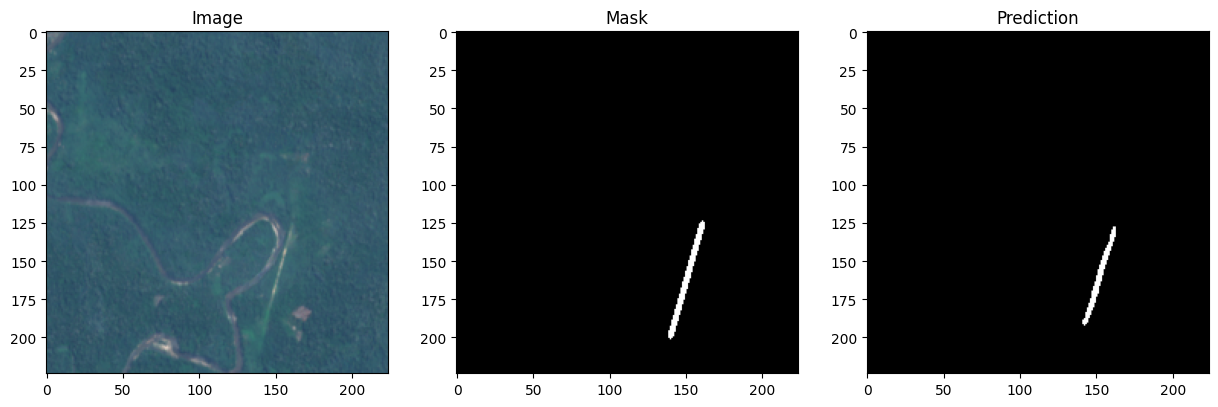

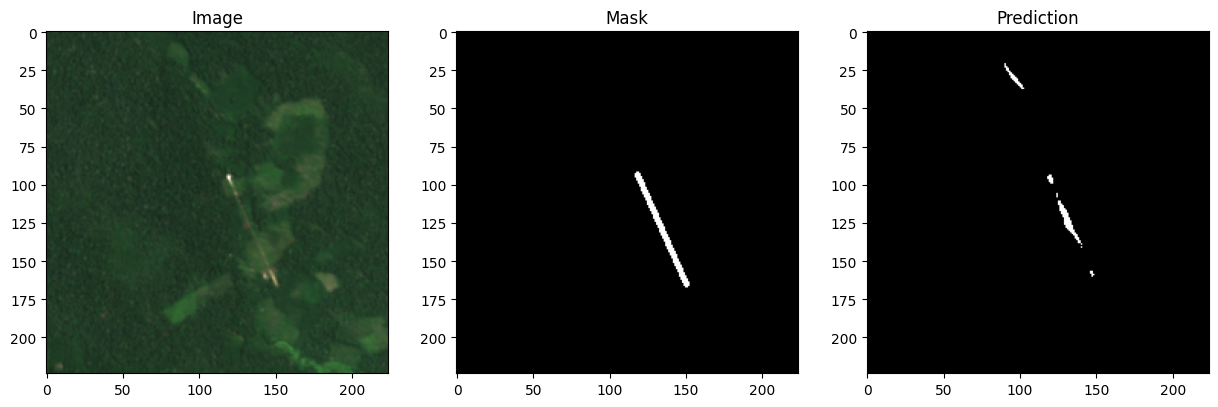

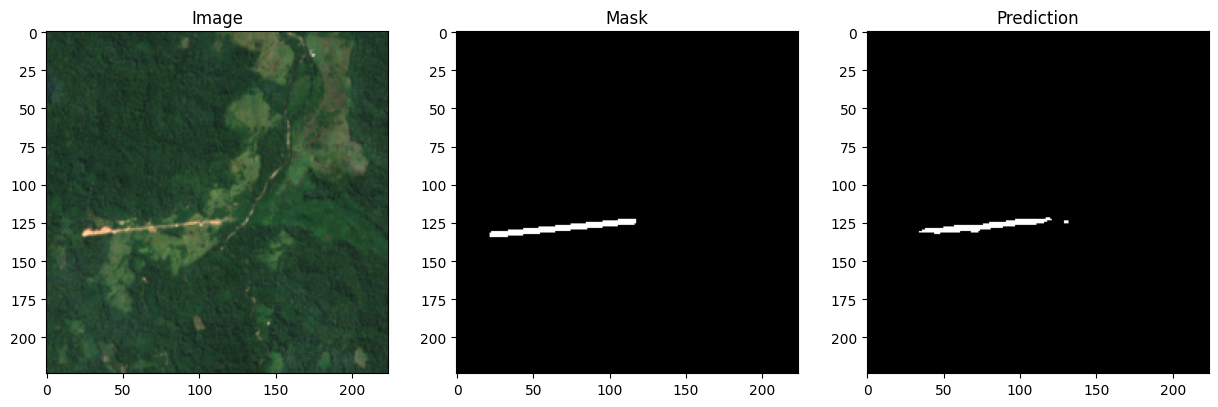

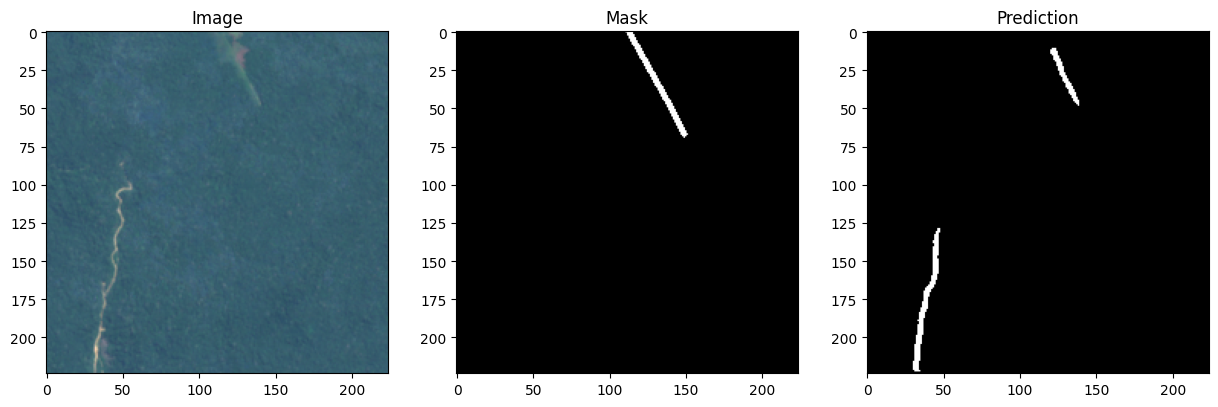

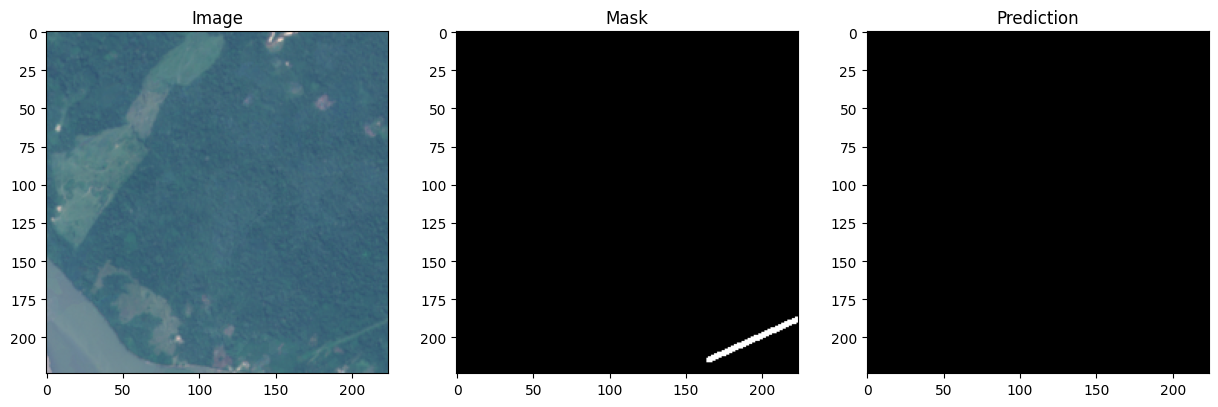

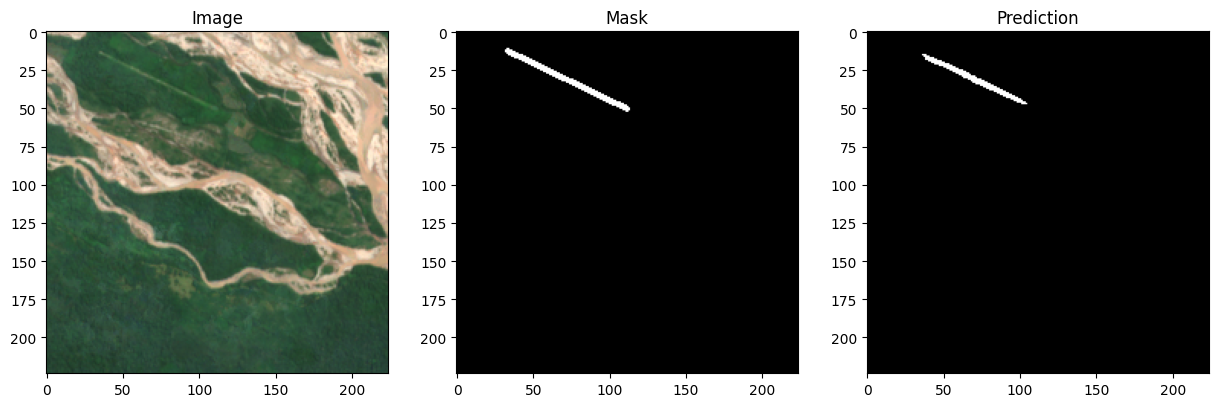

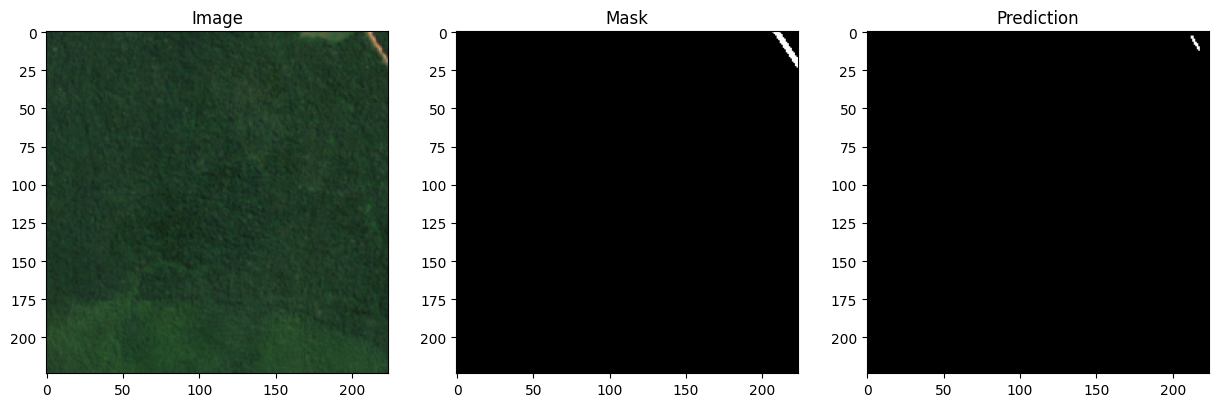

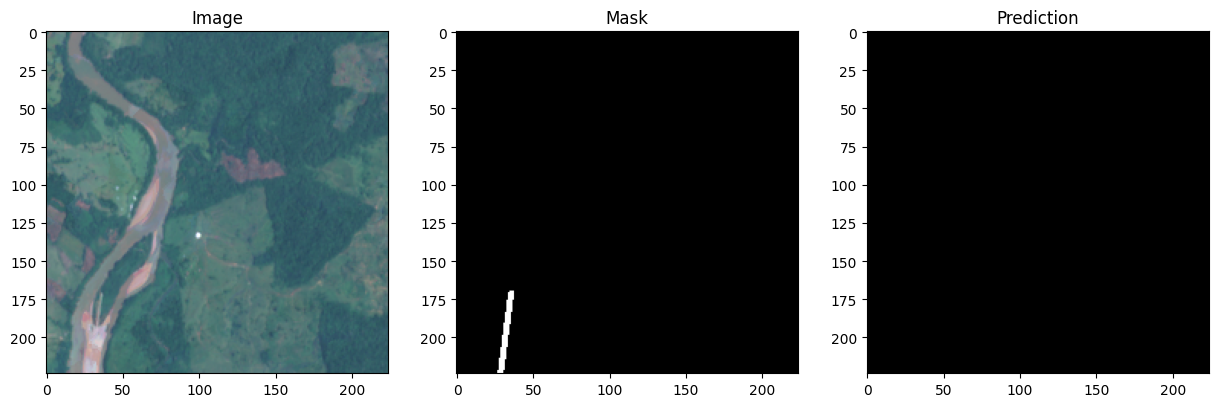

 50%|█████     | 1/2 [00:06<00:06,  6.01s/it]

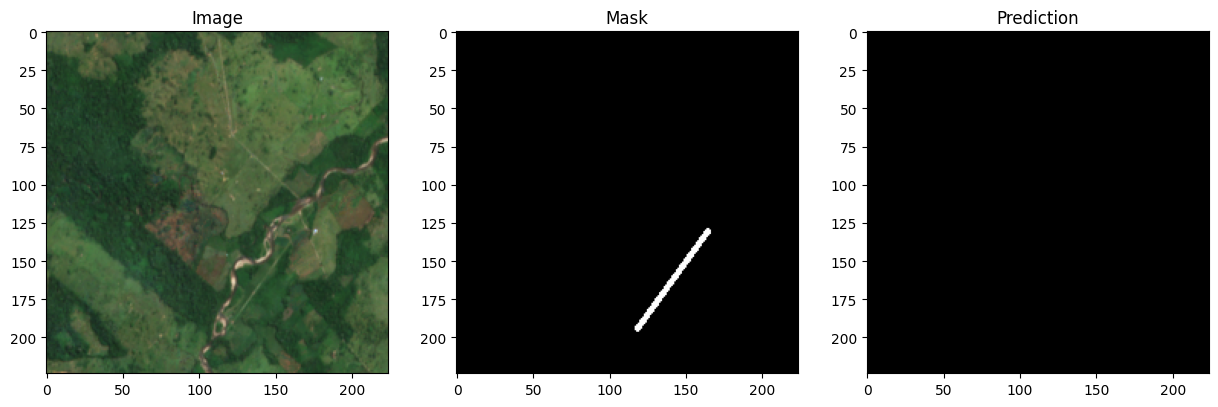

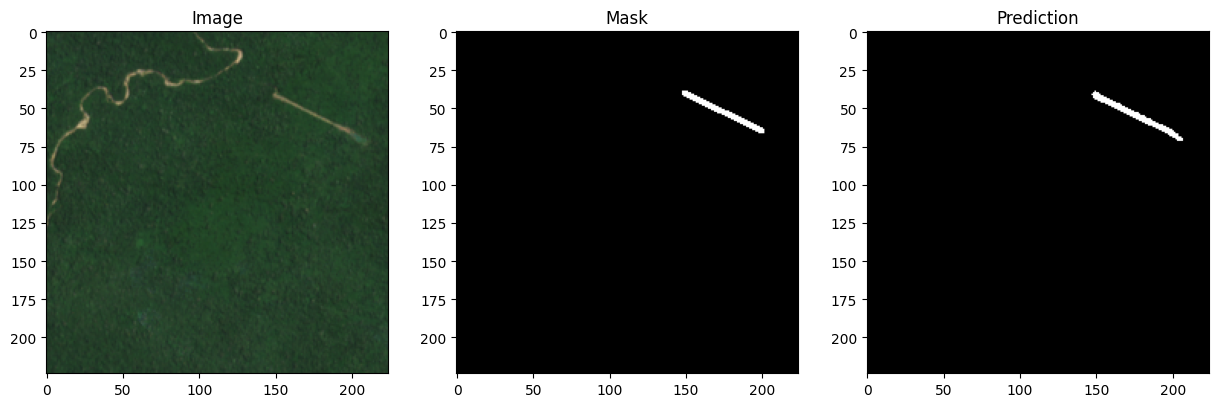

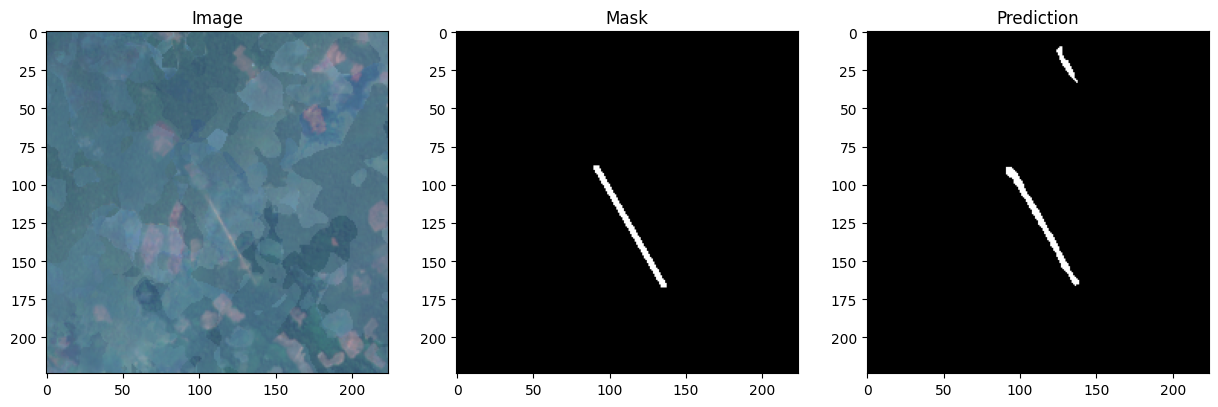

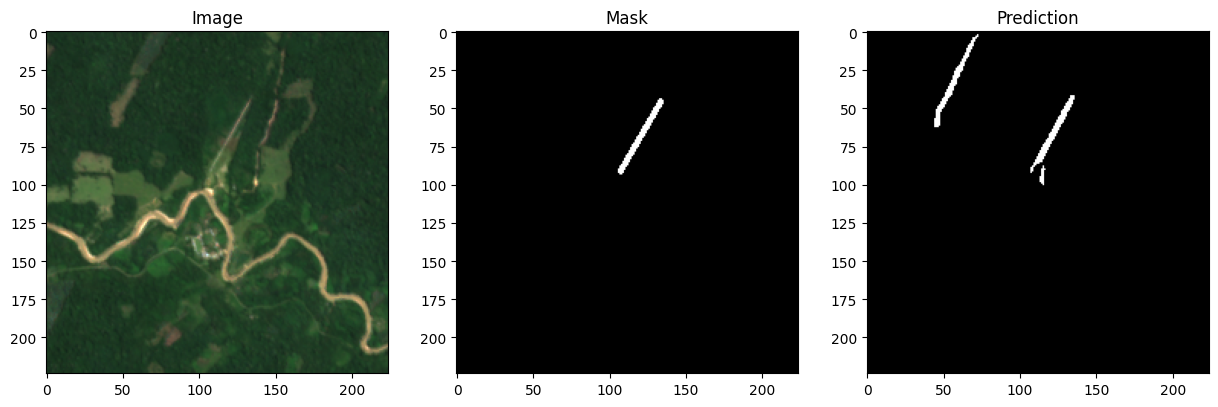

100%|██████████| 2/2 [00:08<00:00,  4.20s/it]

Test Loss: 0.01; Accuracy: 99.48
Average Jaccard Index (IoU): 0.2998


In [ ]:
test_loss = evaluate(best_model, test_loader, criterion, device=device, phase="test", plot=True)

## Save Model

Let's define a function for saving the model to our local Google drive as follows.

In [ ]:
# model_dir = "/content/drive/My Drive/Colab Notebooks/models/"
# if not os.path.exists(model_dir):
#   os.makedirs(model_dir)

# model_file = os.path.join(model_dir, 'zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV.pth')
# model_file

In [ ]:
# def save_model(best_model, model_file):
#   torch.save(best_model.state_dict(), model_file)
#   print('Model successfully saved to {}.'.format(model_file))

In [ ]:
# save_model(best_model, model_file)

## Visualization of the model prediction

Let's load the model, create a data loader for the entire dataset only with center cropping, get a prediction, and plot the results using an animated GIF. This could be useful for identifying issues with different models.

In [ ]:
# try:
#     del model  # Try to delete the model
# except NameError:
#     pass  # If the model isn't defined, do nothing

# # Load the model
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = get_model(in_channels=5).to(device)
# model_path = '/content/drive/MyDrive/Colab Notebooks/models/zindi_best_model_20241030_20m_lr0005_B4_B3_B2_B8_VV.pth'
# #model.load_state_dict(torch.load(model_path))
# model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


# # Set the model to evaluation mode
# model.eval()


In [ ]:
# image_dir = 'drive/MyDrive/Sentinel_training'
# mask_dir = 'drive/MyDrive/training_masks'
# output_gif = 'Inference_20m_B4_B3_B2_B8_VV.gif'

# # Navigate to the base directory
# %cd /content/


# # List image and mask file paths
# image_paths = [os.path.join(image_dir, img) for img in sorted(os.listdir(image_dir)) if img.endswith('.tif')]
# mask_paths = [os.path.join(mask_dir, mask) for mask in sorted(os.listdir(mask_dir)) if mask.endswith('.tif')]

# additional_bands = ['B8','VV']
# inference_data = Sentinel2Dataset(image_paths=image_paths,
#                               mask_paths=mask_paths,
#                               transform=get_augmentations(option='inference', optional_bands=additional_bands),
#                               additional_bands=additional_bands)


# batch_size = 8
# num_workers = 2

# inference_loader = DataLoader(inference_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)


# imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# animation_images = []

# # Create a new rasterio dataset with basic metadata
# transform = rasterio.Affine(10.0, 0.0, 410245, 0.0, -10.0, 9296903) # basic transformation, consider modifying
# profile = {
#     'driver': 'GTiff',
#     'height': 224,
#     'width': 224,
#     'count': 1,  # Update if your prediction has multiple bands
#     'dtype': rasterio.uint8,  # Update data type if necessary
#     'crs': 'EPSG:32718',  # Update with the correct CRS if known
#     'transform': transform,
# }



# for i, (images, masks) in enumerate(inference_loader):
#     images = images.to(device)
#     masks = masks.to(device)

#     # Add channel dimension to the target masks
#     masks = masks.type(torch.float32)
#     masks = masks.unsqueeze(1)


#     with torch.set_grad_enabled(False):
#         outputs = model(images)
#         loss = criterion(outputs, masks)
#         # Apply sigmoid to the outputs (for binary segmentation) and threshold
#         preds = torch.sigmoid(outputs) > 0.5


#     # Plot image, mask, and prediction for a sample in the batch
#     for j in range(images.shape[0]):  # Loop through batch
#         image = images[j, :3, :, :].cpu().permute(1, 2, 0).numpy()  # Move to CPU, permute for plotting
#         image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)
#         mask = masks[j].cpu().squeeze().numpy()
#         prediction = outputs[j].cpu().squeeze()

#         # Apply sigmoid for binary segmentation if your model output is logits.
#         prediction = torch.sigmoid(prediction)

#         # Threshold predictions (adjust threshold as needed)
#         prediction = (prediction > 0.5).float().numpy()  # Example threshold of 0.5

#         #plot_predictions(image, mask, prediction) # Call plot function
#         """Plots the image, mask, and prediction side-by-side."""
#         fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
#         ax1.imshow(image)
#         ax1.set_title("Image")
#         ax2.imshow(mask, cmap='gray')
#         ax2.set_title("Mask")
#         ax3.imshow(prediction, cmap='gray')
#         ax3.set_title("Prediction")
#         #plt.show()
#         temp_file = 'temp_plot.png'
#         plt.savefig(temp_file)
#         plt.close()
#         animation_images.append(imageio.imread(temp_file))
#         os.remove(temp_file)

#         # Save prediction to GeoTIFF file for statistical studies
#         #filename = f'/content/drive/MyDrive/Zindi-Amazon/Studies/training_predictions/pred_{i:02}_{j:02}.tif'
#         #with rasterio.open(filename, 'w', **profile) as dst:  # Replace with your desired output file path
#         #    dst.write(prediction.astype(rasterio.uint8), 1)  # Cast prediction to the correct data type

# imageio.mimsave(output_gif, animation_images, fps=0.5)







